# SIR model simulation of the Kermack & McKendrick EDO system.

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from scipy.integrate import odeint

In [45]:
# Constants
states = {
    'S': 0, # Susceptible
    'I': 1, # Infected
    'R': 2, # Recovered
}

In [46]:
# Parameters
M, N = 32, 32 # Grid size
T = 100 # Number of time steps
I_0 = 5 # Initial number of infected individuals
rad = 1 # Interaction radius
beta = 0.3 # Infection rate (0 <= beta <= 1)
gamma = 0.05 # Recovery rate (0 <= gamma <= 1)

### Model Functions

In [47]:
def initGrid(M, N, I_0, initial_positions=None):
    """
    Initialize the grid with susceptible and infected individuals.

    Args:
    M, N (int): Grid dimensions
    I_0 (int): Number of initial infected individuals
    initial_positions (list): Optional list of (x, y) tuples for initial infected positions

    Returns:
    numpy.ndarray: Initialized grid
    """
    grid = np.zeros((M, N))
    if initial_positions is None:
        for i in range(I_0):
            x, y = np.random.randint(0, M), np.random.randint(0, N)
            grid[x, y] = 1
    else:
        for x, y in initial_positions:
            grid[x, y] = 1
    return grid

In [48]:
def getNeighbors(x, y, M, N, rad):
    """
    Get the neighbors of a cell within a given radius.

    Args:
    x, y (int): Cell coordinates
    M, N (int): Grid dimensions
    rad (int): Radius for neighborhood

    Returns:
    list: List of neighboring cell coordinates
    """
    neighbors = []
    for i in range(-rad, rad + 1):
        for j in range(-rad, rad + 1):
            if i == 0 and j == 0:
                continue
            if 0 <= x + i < M and 0 <= y + j < N:
                neighbors.append((x + i, y + j))
    return neighbors

In [49]:
def nextIteration(grid, rad, beta, gamma):
    """
    Compute the next iteration of the SIR model.

    Args:
    grid (numpy.ndarray): Current state of the grid
    rad (int): Radius for neighborhood
    beta (float): Infection rate
    gamma (float): Recovery rate

    Returns:
    tuple: Updated grid and counts of S, I, R individuals
    """
    I, S, R = 0, 0, 0
    M, N = grid.shape
    newGrid = np.zeros((M, N))
    for i in range(M):
        for j in range(N):
            if grid[i, j] == states['S']:
                S += 1
                infected_neighbors = sum(1 for x, y in getNeighbors(i, j, M, N, rad) if grid[x, y] == states['I'])
                if infected_neighbors > 0 and np.random.random() < 1 - (1 - beta) ** infected_neighbors:
                    newGrid[i, j] = states['I']
                else:
                    newGrid[i, j] = states['S']
            elif grid[i, j] == states['I']:
                I += 1
                if np.random.random() < gamma:
                    newGrid[i, j] = states['R']
                else:
                    newGrid[i, j] = states['I']
            else:
                R += 1
                newGrid[i, j] = states['R']
    return newGrid, S, I, R

### Utility functions

In [163]:
def createAnimation(gridHist, filename='sir_simulation', format='gif'):
    """
    Create and save a gif of the grid evolution, showing the step number on each frame.

    Args:
    gridHist (list): List of grid states over time
    filename (str): Name of the output gif file
    format (str): Format of the output file (default: 'gif' | 'mp4')
    """
    fig, ax = plt.subplots()
    ims = []
    for t, grid in enumerate(gridHist):
        im = ax.imshow(grid, cmap='viridis', animated=True)
        text = ax.text(0.02, 0.95, f'Step: {t}', transform=ax.transAxes, color='white',
                       fontweight='bold', bbox=dict(facecolor='black', alpha=0.5))
        ims.append([im, text])

    if format == 'gif':
        ani = animation.ArtistAnimation(fig, ims, interval=200, blit=False, repeat_delay=1000)
        ani.save(f'{filename}.gif', writer='pillow')
    elif format == 'mp4':
        ani = animation.ArtistAnimation(fig, ims, interval=200, blit=False, repeat_delay=1000)
        ani.save(f'{filename}.mp4', writer='ffmpeg')

    plt.close()

In [161]:
def evolutionPlot(SHist, IHist, RHist):
    """
    Plot the evolution of S, I, R populations over time.

    Args:
    SHist, IHist, RHist (list): Lists of S, I, R counts over time
    """
    plt.figure(figsize=(10, 6))
    plt.plot(SHist, label='Susceptible')
    plt.plot(IHist, label='Infected')
    plt.plot(RHist, label='Recovered')
    plt.xlabel('Time')
    plt.ylabel('Number of individuals')
    plt.legend()
    plt.title('SIR Model Simulation')
    plt.show()

### Simulation Functions

In [52]:
def simulation(M, N, T, I_0, rad, beta, gamma, initial_positions=None):
    """
    Run a complete SIR model simulation.

    Args:
    M, N (int): Grid dimensions
    T (int): Number of time steps
    I_0 (int): Number of initial infected individuals
    rad (int): Radius for neighborhood
    beta (float): Infection rate
    gamma (float): Recovery rate
    initial_positions (list): Optional list of (x, y) tuples for initial infected positions

    Returns:
    tuple: Lists of grid states and S, I, R counts over time
    """
    gridHist = []
    IHist = []
    SHist = []
    RHist = []
    grid = initGrid(M, N, I_0, initial_positions)
    for _ in range(T):
        grid, S, I, R = nextIteration(grid, rad, beta, gamma)
        gridHist.append(grid)
        SHist.append(S)
        IHist.append(I)
        RHist.append(R)
    return gridHist, SHist, IHist, RHist

In [53]:
def runMultipleSimulations(M, N, T, I_0, rad, beta, gamma, N_exp, initial_positions=None):
    """
    Run multiple simulations and compute average dynamics.

    Args:
    M, N (int): Grid dimensions
    T (int): Number of time steps
    I_0 (int): Number of initial infected individuals
    rad (int): Radius for neighborhood
    beta (float): Infection rate
    gamma (float): Recovery rate
    N_exp (int): Number of experiments to run
    initial_positions (list): Optional list of (x, y) tuples for initial infected positions

    Returns:
    tuple: Average S, I, R counts and grid states over time
    """
    all_S = np.zeros((N_exp, T))
    all_I = np.zeros((N_exp, T))
    all_R = np.zeros((N_exp, T))
    all_grids = np.zeros((N_exp, T, M, N))

    for i in range(N_exp):
        gridHist, SHist, IHist, RHist = simulation(M, N, T, I_0, rad, beta, gamma, initial_positions)
        all_S[i] = SHist
        all_I[i] = IHist
        all_R[i] = RHist
        all_grids[i] = gridHist

    avg_S = np.mean(all_S, axis=0)
    avg_I = np.mean(all_I, axis=0)
    avg_R = np.mean(all_R, axis=0)
    avg_grids = np.mean(all_grids, axis=0)

    return avg_S, avg_I, avg_R, avg_grids

### Evaluation Functions

In [54]:
def theoretical_sir_model(y, t, N, beta, gamma):
    """
    Corrected differential equations for the theoretical SIR model.

    Args:
    y (tuple): Current state (S, I, R)
    t (float): Current time
    N (int): Total population
    beta (float): Infection rate
    gamma (float): Recovery rate

    Returns:
    tuple: Rate of change for S, I, R
    """
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [55]:
def run_theoretical_sir(S0, I0, R0, N, beta, gamma, T):
    """
    Run the theoretical SIR model.

    Args:
    S0, I0, R0 (int): Initial number of susceptible, infected, and recovered individuals
    N (int): Total population
    beta (float): Infection rate
    gamma (float): Recovery rate
    T (int): Number of time steps

    Returns:
    tuple: Arrays of S, I, R values over time
    """
    t = np.linspace(0, T-1, T)
    y0 = S0, I0, R0
    ret = odeint(theoretical_sir_model, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    return S, I, R

In [56]:
def normalize_data(data, total_population):
    """
    Normalize data to 0-1 scale.

    Args:
    data (array): Data to normalize
    total_population (int): Total population for scaling

    Returns:
    array: Normalized data
    """
    return data / total_population


In [168]:
def compare_plot_normalized(avg_S, avg_I, avg_R, theo_S, theo_I, theo_R, total_population, title='Comparison of Simulated and Theoretical SIR Models'):
    """
    Create a comparison plot of normalized simulated and theoretical results.

    Args:
    avg_S, avg_I, avg_R (array): Average simulated S, I, R values
    theo_S, theo_I, theo_R (array): Theoretical S, I, R values
    total_population (int): Total population for normalization

    Returns:
    None (displays the plot)
    """
    plt.figure(figsize=(12, 8))
    plt.plot(normalize_data(avg_S, total_population), label='Simulated S', linestyle='--')
    plt.plot(normalize_data(avg_I, total_population), label='Simulated I', linestyle='--')
    plt.plot(normalize_data(avg_R, total_population), label='Simulated R', linestyle='--')
    plt.plot(normalize_data(theo_S, total_population), label='Theoretical S')
    plt.plot(normalize_data(theo_I, total_population), label='Theoretical I')
    plt.plot(normalize_data(theo_R, total_population), label='Theoretical R')
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [58]:
def calculate_normalized_mse(avg_S, avg_I, avg_R, theo_S, theo_I, theo_R, N_total):
    """
    Calculate the normalized Mean Squared Error for SIR model components.

    Args:
    avg_S, avg_I, avg_R (array): Average simulated S, I, R values
    theo_S, theo_I, theo_R (array): Theoretical S, I, R values
    N_total (int): Total population for normalization

    Returns:
    tuple: MSE values for S, I, R, and total MSE
    """
    def normalize_data(data):
        return data / N_total

    mse_S = np.mean((normalize_data(avg_S) - normalize_data(theo_S))**2)
    mse_I = np.mean((normalize_data(avg_I) - normalize_data(theo_I))**2)
    mse_R = np.mean((normalize_data(avg_R) - normalize_data(theo_R))**2)
    total_mse = mse_S + mse_I + mse_R

    return mse_S, mse_I, mse_R, total_mse

## Testing the model

In [59]:
# M, N = 100, 100  # Grid dimensions
# T = 200  # Number of time steps
# I_0 = 5  # Increase initial infected for faster spread
# rad = 1  # Interaction radius
# beta = 0.3  # Increase infection rate
# gamma = 0.1  # Decrease recovery rate
# N_exp = 50  # Increase number of experiments

In [157]:
# # Single simulation
# gridHist, SHist, IHist, RHist = simulation(M, N, T, I_0, rad, beta, gamma)
# createGif(gridHist)
# evolutionPlot(SHist, IHist, RHist)

In [61]:
# Multiple simulations
# N_exp = 50
# avg_S, avg_I, avg_R, avg_grids = runMultipleSimulations(M, N, T, I_0, rad, beta, gamma, N_exp)
# evolutionPlot(avg_S, avg_I, avg_R)
# createGif(avg_grids, 'average_sir_simulation.gif')

In [62]:
# Simulation with predefined initial positions
# initial_positions = [(50, 50), (25, 25), (75, 75), (25, 75), (75, 25)]
# gridHist, SHist, IHist, RHist = simulation(M, N, T, I_0, rad, beta, gamma, initial_positions)
# createGif(gridHist, 'predefined_sir_simulation.gif')
# evolutionPlot(SHist, IHist, RHist)

# Ejercicios

## Ejercicio 1

## Ejercicio 2

In [167]:
M, N = 100, 100  # Grid dimensions
T = 130  # Number of time steps
I_0 = 2  # Increase initial infected for faster spread
rad = 1  # Interaction radius
beta = 0.1  # Increase infection rate
gamma = 0.25  # Decrease recovery rate
N_exp = 50  # Number of experiments

N_total = M * N
avg_S, avg_I, avg_R, avg_grids = runMultipleSimulations(M, N, T, I_0, rad, beta, gamma, N_exp)

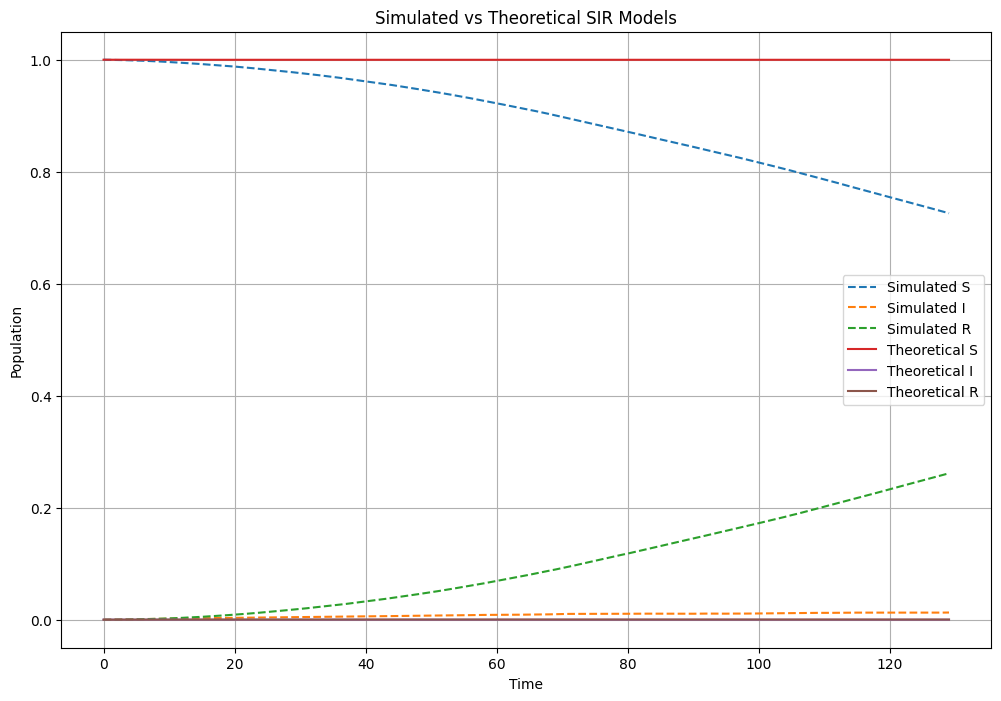

Normalized Mean Squared Error:
S: 0.018084689406363312
I: 8.03249014516519e-05
R: 0.015874054732266375
Total: 0.03403906904008134


In [171]:
# Run theoretical model
S0, I0, R0 = N_total - I_0, I_0, 0
theo_S, theo_I, theo_R = run_theoretical_sir(S0, I0, R0, N_total, beta, gamma, T)

# Create normalized comparison plot
compare_plot_normalized(avg_S, avg_I, avg_R, theo_S, theo_I, theo_R, N_total, title='Simulated vs Theoretical SIR Models')

# Calculate normalized Mean Squared Error
mse_S, mse_I, mse_R, total_mse = calculate_normalized_mse(avg_S, avg_I, avg_R, theo_S, theo_I, theo_R, N_total)

print(f"Normalized Mean Squared Error:")
print(f"S: {mse_S}")
print(f"I: {mse_I}")
print(f"R: {mse_R}")
print(f"Total: {total_mse}")